# Comparison between SODAR and FlyFOX

In [1]:
# This script generates a number of useless warnings
# like oh no you divided by zero, which is quite
# normal for this sort of analysis.
import warnings
warnings.filterwarnings("ignore")

# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import scipy
import pandas as pd
import copy
import pyfocs

# Wavelets
import pywt
import pycwt as wavelet
from pycwt.helpers import find

# OS/file interaction
import os

# import plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import dates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from matplotlib import ticker
from matplotlib import colors
import itertools
import string


In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = pyfocs.dts_plots.sron(6)
sns.set_palette(sns.color_palette(flatui))
alphabet = list(string.ascii_lowercase)

## Data directories

In [3]:
# Determine which computer I am on
computer = os.environ.get('LOCALNAME')
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'sublayer-detection')

# SODAR
dir_rs = os.path.join(dir_pre, 'remote_sensing')
dir_sodar = os.path.join(dir_rs, 'sodar')
dir_press = os.path.join(dir_pre, 'logger_data', 'pressure')
dir_aws_data = os.path.join(dir_pre, 'logger_data', 'AWS')


# Function definitions

These are mostly for converting between thermodynamic quantities.

In [4]:
def potential_temperature(T, p_0, p):
    R = 287.058 # [J/(kg K)]
    cp = 1004 # [J / (K kg)]
    R_cp = 0.286 # Use the approximate value for ease

    # Make sure we are in Kelvin
    if np.max(T) < 200:
        T = T + 273.15

    theta = T * (p_0 / p) ** (R_cp)
    return theta


def virtual_temp(T, r_v, r_l=0):
    # Equation 2, virtual temperature

    # Make sure we are in celsius
    if np.max(T) < 200:
        T = T + 273.15
    T_v = T * (1 + 0.61 * r_v - r_l)
    return T_v


def sonic_temp_conversion(Ts, q):
    T_air = Ts / (1 + 0.51 * q)
    return T_air


def temp_sonic_conversion(Tair, q):
    Ts = Tair * (1 + 0.51 * q)
    return Ts


def mixing_ratio(e, p):
    # Equation 3a, mixing ratio of water vapor
    # e is water vapor pressure in hPa
    # p is air pressure in hPa
    r_v = 0.622 * e / (p - 0.378 * e)
    return r_v


def e_s_wmo(T):
    # Equation 3b Saturated water vapor pressure
    
    # Make sure we are in celsius
    if np.max(T) > 200:
        T = T - 273.15
    
    # Constants
    c1 = 6.112
    c2 = 17.62
    c3 = 243.12
    
    # WMO approximation
    e_s = c1 * np.exp(c2 * T / (c3 + T))
    return e_s


def hypsometric_press(p_ref, z, z_ref, T_v):
    # Equation 4, hypsometric equation for pressure.
    # T_v is in Kelvin and is the average virtual temperature
    # between layers.
    # p_ref is the pressure at the reference height (e.g., the surface)

    # Make sure we are in Kelvin
    if np.max(T_v) < 200:
        T_v = T_v + 273.15
    
    R = 287.058 # [J/(kg K)]
    g = 9.81 # [m/s^2]
    
    p = p_ref * np.exp(-g * (z - z_ref) / (R * T_v))
    return p

# Load data

## FlyFOX-V

In [5]:
# UTC flight times for the AGU subset
flight_times = {'LOVE-Flyfox-190718': ['2019-07-18 3:08', '2019-07-18 6:54'],
                'LOVE-Flyfox-190722': ['2019-07-22 3:18', '2019-07-22 6:10'],
                'LOVE-Flyfox-190723': ['2019-07-23 2:59', '2019-07-23 6:30'],
                'LOVE-Flyfox-190724': ['2019-07-24 18:13', '2019-07-24 19:55'],
                'LOVE-Flyfox-190726': ['2019-07-26 3:21', '2019-07-26 6:24'],
               }

# July 18th
exp_name = 'LOVE-Flyfox-190718'
dir_dts_data = os.path.join(dir_pre, 'love_dts', exp_name)
os.chdir(dir_dts_data)
ff_18 = xr.open_dataset('flyfox_180719_thetav.nc')


# July 22nd
exp_name = 'LOVE-Flyfox-190722'
dir_dts_data = os.path.join(dir_pre, 'love_dts', exp_name)
os.chdir(dir_dts_data)
ff_22 = xr.open_dataset('flyfox_220719_thetav.v2-2021-06-01.nc')

# July 23rd
exp_name = 'LOVE-Flyfox-190723'
dir_dts_data = os.path.join(dir_pre, 'love_dts', exp_name)
os.chdir(dir_dts_data)
ff_23 = xr.open_dataset('flyfox_230719_thetav.v2-2021-06-01.nc')
ff_23 = ff_23.sel(time=slice(flight_times[exp_name][0], flight_times[exp_name][1]))

# July 24th
exp_name = 'LOVE-Flyfox-190724'
dir_dts_data = os.path.join(dir_pre, 'love_dts', exp_name)
os.chdir(dir_dts_data)
ff_24 = xr.open_dataset('flyfox_240719_thetav.v2-2021-06-01.nc')

# July 26th
exp_name = 'LOVE-Flyfox-190726'
dir_dts_data = os.path.join(dir_pre, 'love_dts', exp_name)
os.chdir(dir_dts_data)
ff_26 = xr.open_dataset('flyfox_260719_thetav.v2-2021-06-01.nc')

flight_dict = {'LOVE-Flyfox-190718': ff_18,
               'LOVE-Flyfox-190722': ff_22,
               'LOVE-Flyfox-190723': ff_23,
               'LOVE-Flyfox-190724': ff_24,
               'LOVE-Flyfox-190726': ff_26,
              }

## SODAR-RASS

In [6]:
os.chdir(dir_sodar)
sodar = xr.open_dataset('LOVE_SODAR_JuneJuly.nc')
print(sodar)

<xarray.Dataset>
Dimensions:         (time: 8784, z: 19)
Coordinates:
  * time            (time) datetime64[ns] 2019-05-31T23:00:00 ... 2019-07-31T...
  * z               (z) int64 40 60 80 100 120 140 ... 300 320 340 360 380 400
Data variables:
    temperature     (time, z) float64 ...
    wind_speed      (time, z) float64 ...
    wind_direction  (time, z) float64 ...


## Surface pressure

There are many data gaps, so I will fill them using an estimate from the barometric formula

Text(0.5, 1.0, 'Pressure data with gap filling')

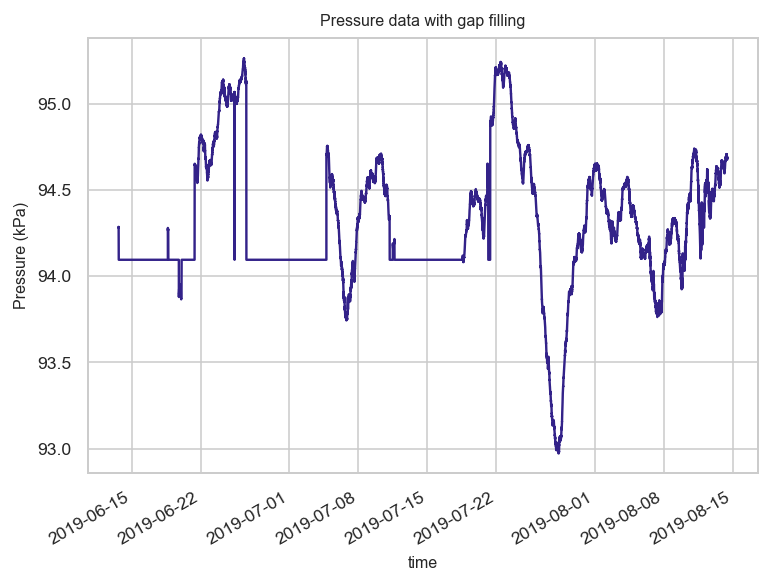

In [7]:
os.chdir(dir_press)
press = xr.open_dataset('pressure_1min_stats.nc')

# Take the average pressure across the 4 stations (convert to kPa)
press_avg = xr.concat([press.P1_Avg, press.P2_Avg, press.P3_Avg, press.P4_Avg,], dim='station')
press_avg = press_avg.mean(dim='station') / 10

# Estimate pressure for the gapped periods with the barometric formula

# Elevation above sea level and the standard sea level pressure
z_site = 620
press_sealvl = 101.325
press_gap = press_sealvl * (1 - 0.0065 * z_site / 288.15) ** 5.255

# Fill the gaps
press_avg = press_avg.reindex(
    time=pd.date_range(
        press_avg.time.values[0],
        press_avg.time.values[-1],
        freq='1min'
    )
)
press_avg = press_avg.where(~np.isnan(press_avg), press_gap)

# Visualize
press_avg.plot()
plt.gca().set_ylabel('Pressure (kPa)')
plt.gca().set_title('Pressure data with gap filling')

## Homogenized potential temperatures from surface stations

In [8]:
os.chdir(os.path.join(dir_pre, 'homogenized_data'))

sonic_1min_sub = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
aws_2m_theta = xr.open_dataarray('aws_pot-temp_1min_qc_tower-subset.v2-2021-06-01.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v2-2021-06-01.nc')

## AWS

We need other AWS quantities as well, and not just the potential temperature which is loaded above.

In [9]:
os.chdir(dir_aws_data)
aws = xr.open_dataset('AWS_Voi_1min.nc')
aws

<xarray.Dataset>
Dimensions:                      (time: 85445)
Coordinates:
  * time                         (time) datetime64[ns] 2019-06-20T14:03:00 .....
Data variables: (12/16)
    air temperature 2m (HMP45)   (time) float64 ...
    air temperature 5cm (PT100)  (time) float64 ...
    prec (pluvio)                (time) float64 ...
    prec (tipping bucket)        (time) float64 ...
    Rad body temp (CNR4)         (time) float64 ...
    rel humidity 2m (HMP45)      (time) float64 ...
    ...                           ...
    soil temp -05 cm             (time) float64 ...
    soil temp -25 cm             (time) float64 ...
    soil temp -50 cm             (time) float64 ...
    wind direction               (time) int64 ...
    windspeed 2m avg             (time) float64 ...
    windspeed 2m max             (time) float64 ...

## Tethersondes

These are the data recorded for FlyFOX on the tethersonde. They also include the paired surface values which are necessary for estimating profiles of pressure and relative humidity.

In [10]:
tether_dict = {
    'Launch_190718': 'LOVE_Flyfox_190718.nc',
    'Launch_190722': 'LOVE_Flyfox_190722.nc',
    'Launch_190723': 'LOVE_Flyfox_190723.nc',
    'Launch_190724': 'LOVE_Flyfox_190724.nc',
    'Launch_190726': 'LOVE_Flyfox_190726.nc',
}
filelist = [os.path.join(dir_pre, 'logger_data', 'flyfox_tethersonde', tl_key, tl_item) for tl_key, tl_item in tether_dict.items()]
ds_teth = xr.open_mfdataset(filelist, combine='by_coords').load()
ds_teth

<xarray.Dataset>
Dimensions:         (time: 75907)
Coordinates:
  * time            (time) datetime64[ns] 2019-07-18T02:15:03 ... 2019-07-26T...
Data variables:
    warmprobe       (time) float64 29.36 29.36 29.36 29.36 ... 34.02 34.02 34.02
    ambientprobe    (time) float64 17.64 17.64 17.64 17.64 ... 23.95 23.95 23.95
    tethered_press  (time) float64 943.5 943.6 943.5 943.5 ... 942.7 942.7 942.7
    sfc_press       (time) float64 943.5 943.5 943.5 943.5 ... nan nan nan nan
    tethered_temp   (time) float64 19.57 19.56 19.57 19.58 ... 26.22 26.22 26.22
    tethered_rh     (time) float64 44.54 44.51 44.56 44.62 ... 40.79 40.77 40.74
    sfc_rh          (time) float64 nan nan nan nan nan ... nan nan nan nan nan

# Convert SODAR to potential temperature

### Pressure

Determine a relationship between tethered pressure and z of the flight. We can use this to derive the SODAR potential temperature

Text(0.5, 0, 'Balloon height (m)')

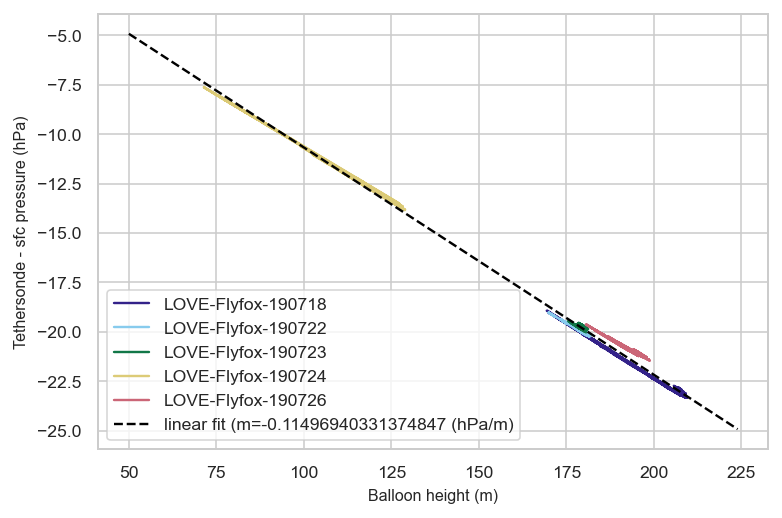

In [11]:
z_list = []
p_list = []
for ff in flight_dict:
    ds_plot = ds_teth.reindex_like(flight_dict[ff].time)
    z_list.extend(flight_dict[ff].top.values)
    p_list.extend(ds_plot.tethered_press.values - ds_plot.sfc_press.values)
    plt.plot(flight_dict[ff].top, ds_plot.tethered_press - ds_plot.sfc_press, label=ff)

p = np.polyfit(z_list, p_list, 1)
fit = np.polyval(p, np.arange(50, 225, 1))
plt.plot(np.arange(50, 225, 1), fit, 'k--', label='linear fit (m={} (hPa/m)'.format(p[0]))
plt.gca().legend()
plt.gca().set_ylabel('Tethersonde - sfc pressure (hPa)')
plt.gca().set_xlabel('Balloon height (m)')

Compare the derived linear value between the surface and tethersonde pressure to the barometric equation.

Text(0.5, 0, 'Elevation (m)')

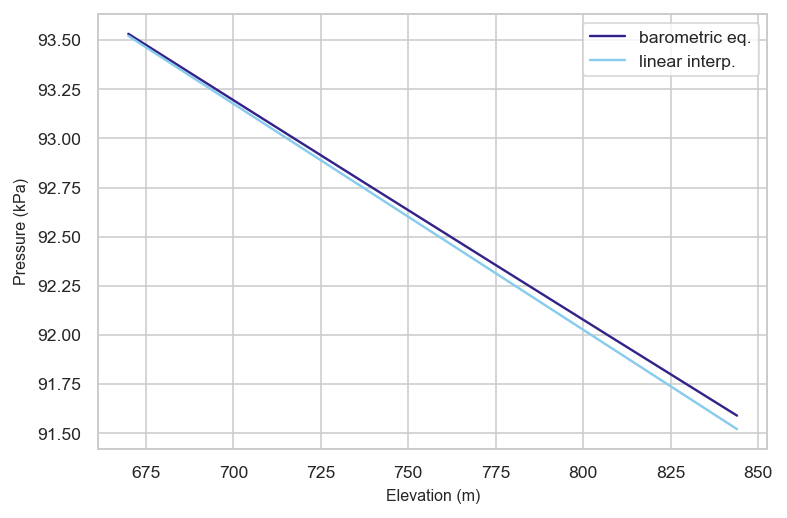

In [12]:
# Estimate pressure for the gapped periods
z_site = 620 # elevatio above sea level
z_elevs = (z_site + np.arange(50, 225, 1))
press_sealvl = 101.325
# Barometric formula
press_hyspo = press_sealvl * (1 - (0.0065 *  z_elevs) / 288.15) ** 5.255

# Linear model
press_linear = press_gap + p[0] * (z_elevs - z_site) / 10

plt.plot(z_elevs, press_hyspo, label='barometric eq.')
plt.plot(z_elevs, press_linear, label='linear interp.')
plt.gca().legend()
plt.gca().set_ylabel('Pressure (kPa)')
plt.gca().set_xlabel('Elevation (m)')

Reassuringly, these give nearly identical slopes/vales. Since the barometric equation is easier to justify and describe, I will just use that instead.

### Specific humidity

This quantity clearly varies with height as the near-surface is almost always more saturated than aloft, as seen in the tethersondes. Consequently, we can only derive humidity related quantities during periods in which we have the tethersonde data.

Here I derive the

1) RH profile

2) The specific humidity/mixing ratio profile. These should be effectively identical, which is great for deriving other different thermodynamic quantities.

The RH and specific humidity profiles are saved to the FlyFOX coordinates since that allows me to easily access the physical properties of the profile like temperature and height of the balloon.

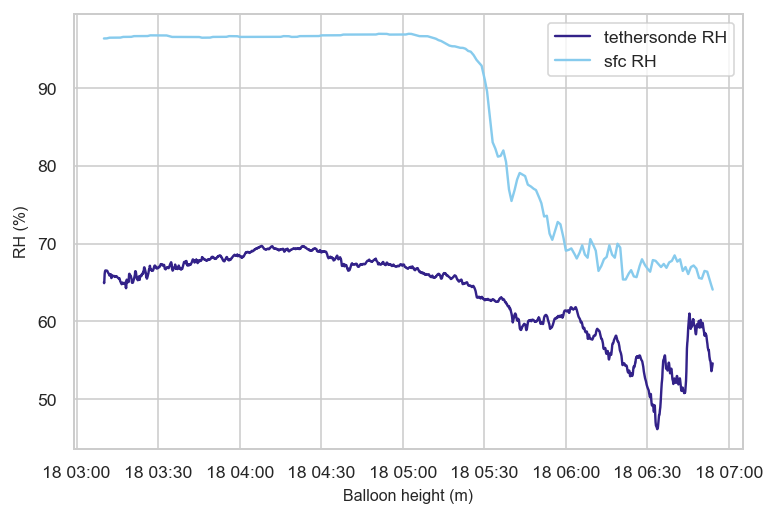

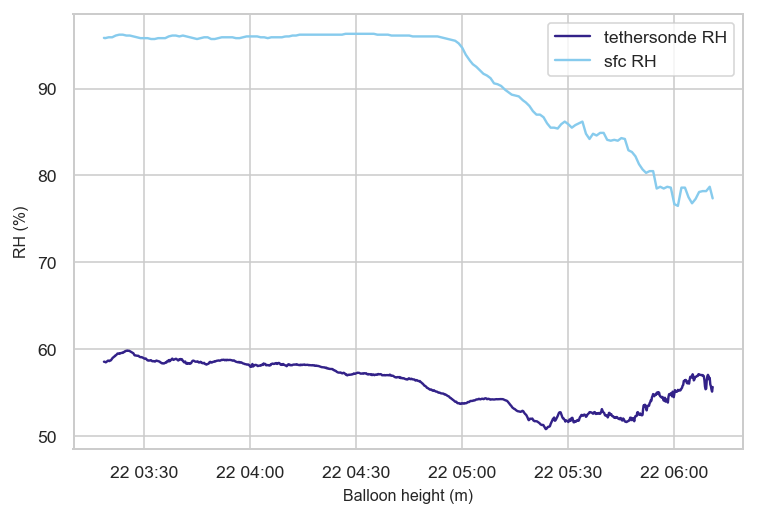

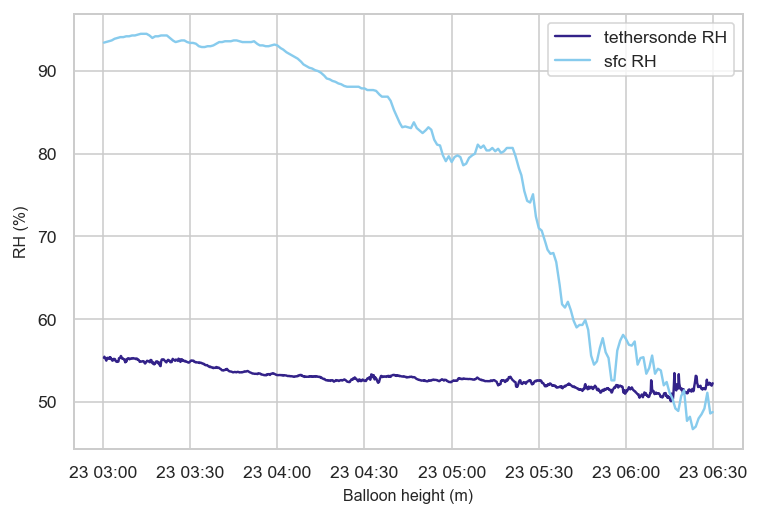

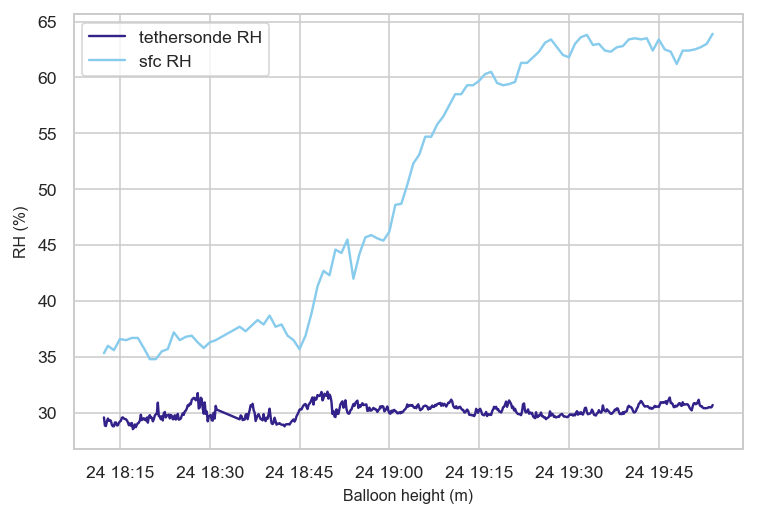

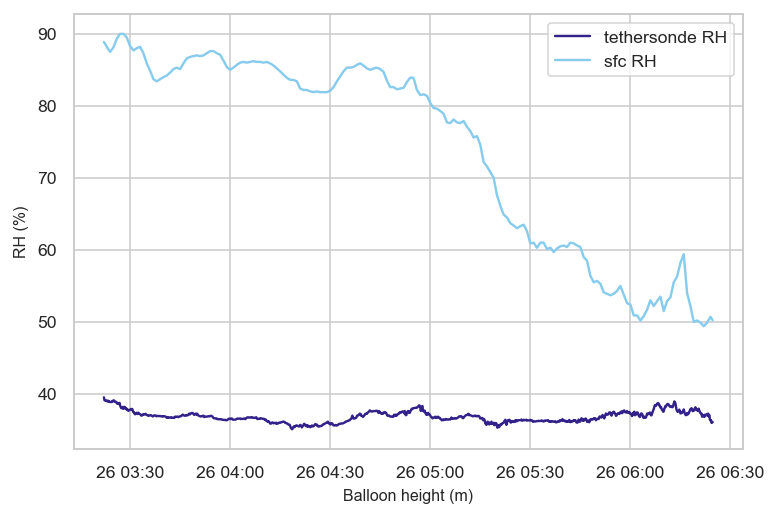

In [13]:
for ff in flight_dict:
    flight_dict[ff]['rh_interp'] = (('time', 'z'), np.zeros((len(flight_dict[ff].time), len(flight_dict[ff].z))))
    flight_dict[ff]['r_v_interp'] = (('time', 'z'), np.zeros((len(flight_dict[ff].time), len(flight_dict[ff].z))))
    ds_ff = flight_dict[ff]

    # Pressure estimate from the barometric formula
    press = press_sealvl * (1 - (0.0065 *  ds_ff.z.values) / 288.15) ** 5.255

    ds_teth_ff = ds_teth.reindex_like(flight_dict[ff].time)


    fig, ax = plt.subplots(1, 1)
    ax.plot(ds_teth_ff.time, ds_teth_ff.tethered_rh, label='tethersonde RH')
    ax.plot(ds_teth_ff.time, ds_teth_ff.sfc_rh, label='sfc RH')

    ax.legend()
    ax.set_ylabel('RH (%)')
    ax.set_xlabel('Balloon height (m)')

    for t in ds_ff.time:
        # Select each time step 
        ds_ff_t = ds_ff.sel(time=t)
        ds_teth_t = ds_teth_ff.sel(time=t)

        # Linearly interpolate RH with z
        x = [2, ds_ff_t.top.values]
        y = [
            ds_teth_t.sfc_rh.values,
            ds_teth_t.tethered_rh.values
        ]
        f_rh = scipy.interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
        rh = f_rh(ds_ff_t.z.values)
        flight_dict[ff]['rh_interp'].loc[dict(time=t)] = rh

        # Saturation vapor pressure
        es = e_s_wmo(ds_ff_t.cal_temp.values)
        # Vapor pressure
        e = es * rh / 100
        # Specific humidity
        r_v = mixing_ratio(e, press * 10)
        # Assign to the flyfox datastructure
        flight_dict[ff]['r_v_interp'].loc[dict(time=t)] = r_v

### Assign and interpolate the relative humidity profile to the sodar data

In [14]:
sodar['r_v_interp'] = (('time', 'z'), np.ones((len(sodar.time), len(sodar.z))) * np.nan)
for ff in flight_dict:
    ds_ff = flight_dict[ff]

    # Get the coordinates
    sodar_interp_coords = sodar.sel(time=slice(ds_ff.time[0], ds_ff.time[-1]), z=slice(None, 220))
    # For points above the observed profile use the mean value at the top of the profile when filling
    fill_value = flight_dict[ff]['r_v_interp'].sel(z=flight_dict[ff].top, method='nearest').mean(dim='time')
    # Finally, interpolate to the sodar coordinates
    sodar['r_v_interp'].loc[dict(time=sodar_interp_coords.time, z=sodar_interp_coords.z)] = flight_dict[ff]['r_v_interp'].dropna("z").dropna('time').interp(
        z=sodar_interp_coords.z, time=sodar_interp_coords.time, kwargs={"fill_value": fill_value}, method="linear",)

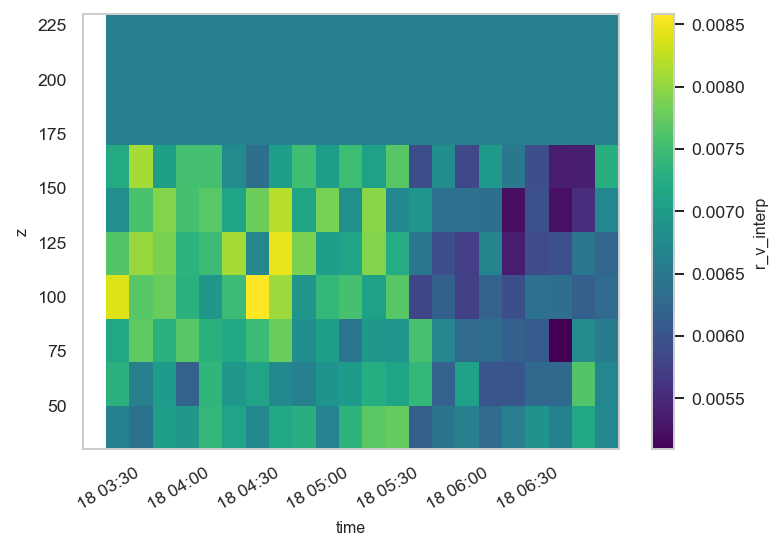

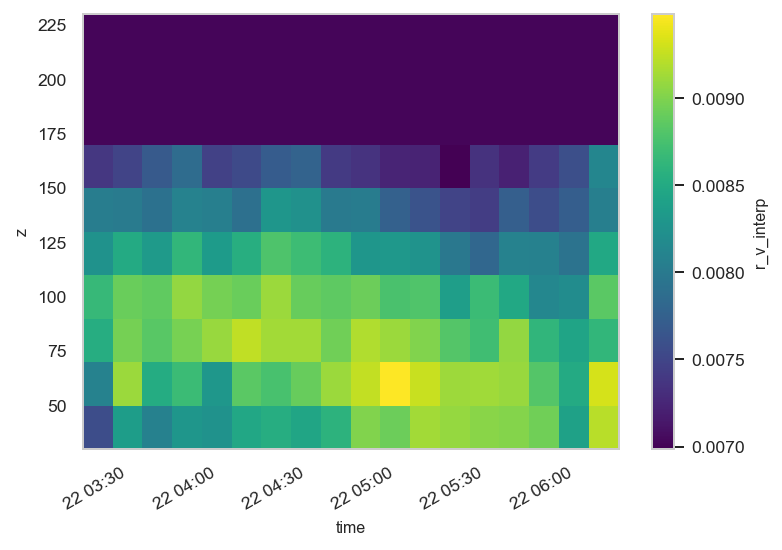

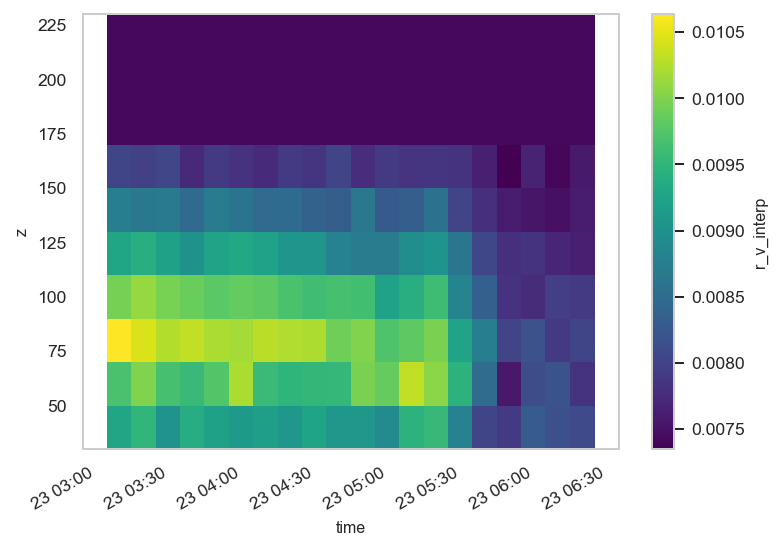

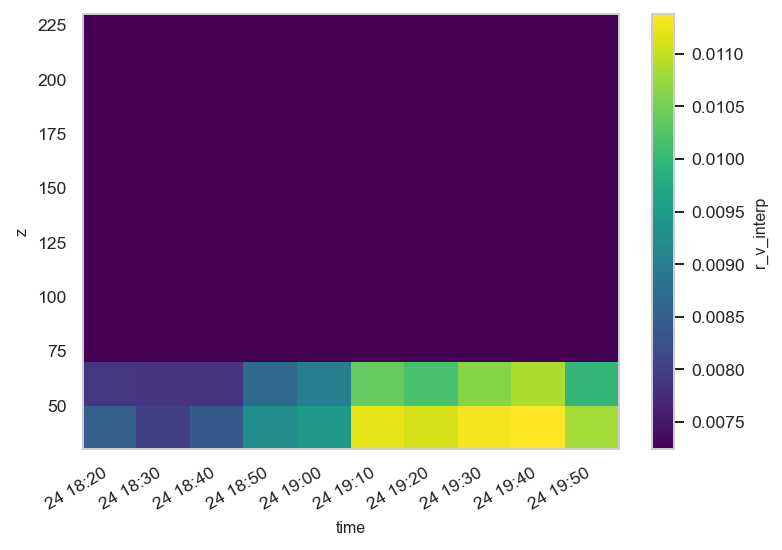

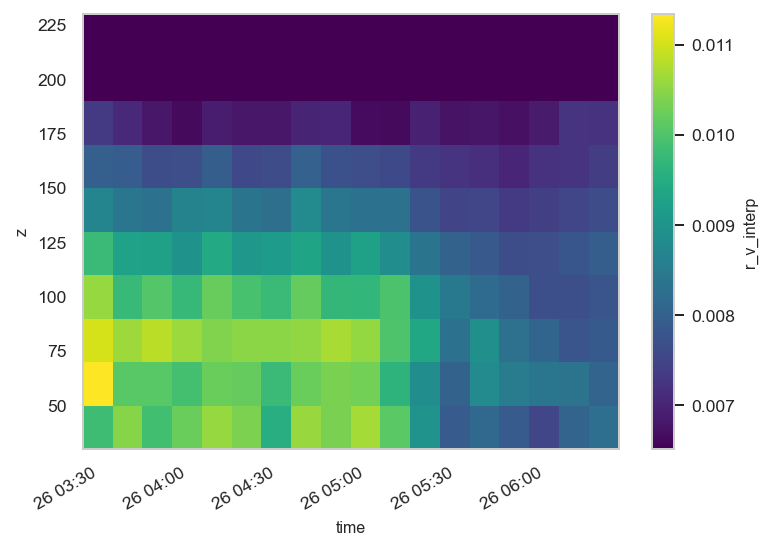

In [15]:
for ff, times in flight_times.items():
    t1 = pd.Timestamp(times[0])
    t2 = pd.Timestamp(times[-1])
    
    plt.figure()
    sodar.sel(time=slice(t1, t2)).sel(z=slice(None, 220)).r_v_interp.T.plot()

### Convert the SODAR temperature from sonic to actual temperature

In [16]:
# NaN out data that are unreasonable
sodar['temperature'] = sodar.temperature.where(
    (sodar.temperature < 40) & (sodar.temperature > -10),
    drop=True
)

# And rename the sodar temperature to virtual temperature
# Catch if I am re-running the cell block and the variable was already renamed
try:
    sodar = sodar.rename({'temperature': 'sonic_temperature'})
except ValueError:
    pass

# Derive the air temperature during periods in which the tethersonde is present
sodar['temperature'] = sonic_temp_conversion(sodar['sonic_temperature'] + 273.15, sodar['r_v_interp'])

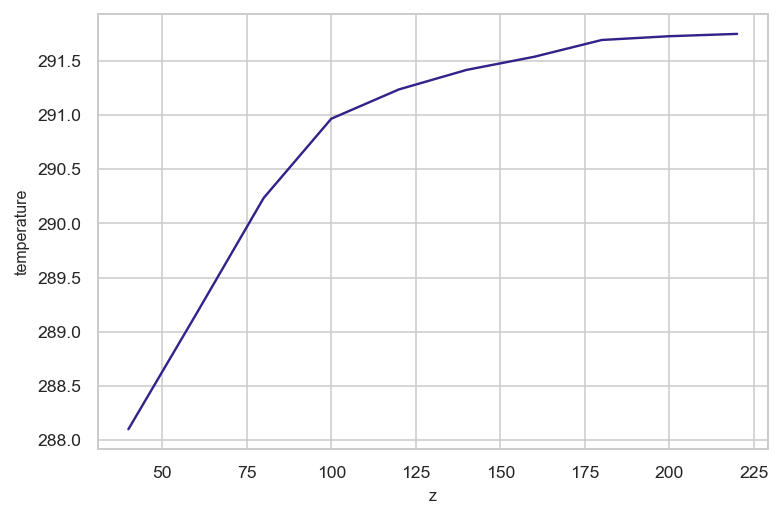

In [17]:
sodar['temperature'].mean(dim='time').plot()

### Estimate pressure profiles

Two assumptions to test:

1) Pressure profile from the barometric formula (`press_baro`)

2) Pressure profile from the barometric formula adjusted by the observed surface pressure (`press_baro_tvary`)

In [18]:
press_baro = press_sealvl * (1 - (0.0065 *  (z_site + sodar.z)) / 288.15) ** 5.255

press_baro_sfc = press_sealvl * (1 - (0.0065 *  (z_site)) / 288.15) ** 5.255
press_diff = press_avg.interp_like(sodar.time) - press_baro_sfc

# Accounts for variations in the surface pressure
press_baro_tvary = press_baro + press_diff.reindex(time=sodar.time)

### Convert to potential temperature

- Assign pressure profiles to the SODAR data
- Derive potential temperature and potential sonic temperature for both pressure assumptions

In [19]:
sodar['press_baro'] = (('z'), press_baro)
sodar['press_baro'].attrs['processing'] = 'Calculated using hydrostatic, isothermal assumption'
sodar['press_baro'].attrs['units'] = 'kPa'

sodar['press_baro_tvary'] = (('z', 'time'), press_baro_tvary)
sodar['press_baro_tvary'].attrs['processing'] = 'Calculated using hydrostatic, isothermal assumption. Corrected by time varying surface pressure'
sodar['press_baro_tvary'].attrs['units'] = 'kPa'

press_stnd_ref = 100
sodar['sonic_theta'] = (('time', 'z'), (sodar.sonic_temperature + 273.15) * (press_stnd_ref / sodar['press_baro']) ** (2 / 7) - 273.15)
sodar['sonic_theta_tvary'] = (('time', 'z'), (sodar.sonic_temperature + 273.15) * (press_stnd_ref / sodar['press_baro_tvary']) ** (2 / 7) - 273.15)
sodar['theta'] = (('time', 'z'), (sodar.temperature) * (press_stnd_ref / sodar['press_baro']) ** (2 / 7) - 273.15)
sodar['theta_tvary'] = (('time', 'z'), (sodar.temperature) * (press_stnd_ref / sodar['press_baro_tvary']) ** (2 / 7) - 273.15)

# Evaluate

### Intercompare SODAR values

We need to determine how the various assumptions impact the values.

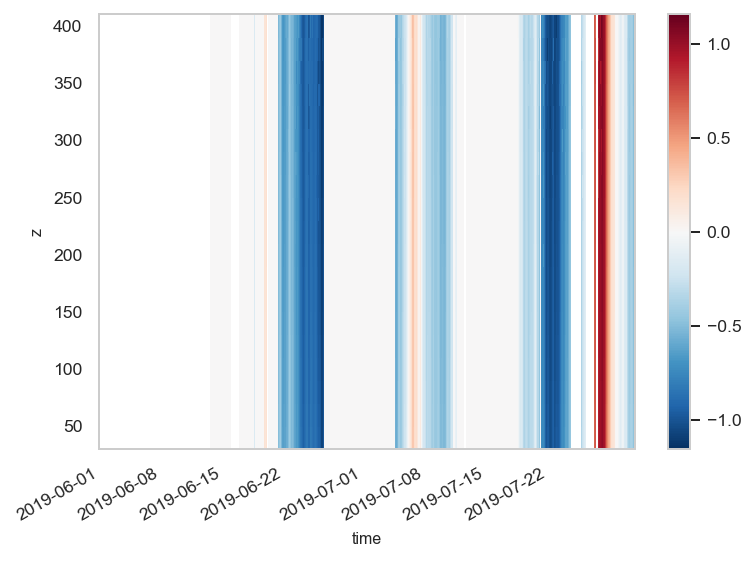

In [20]:
(sodar['sonic_theta_tvary'] - sodar['sonic_theta']).T.plot()

Correcting the barometric formula-derived pressure using the time varying pressure at the surface creates at most +/- 1C changes in the column temperature. There is no change in the periods in which we gap fill the pressure observations using the barometric formula.

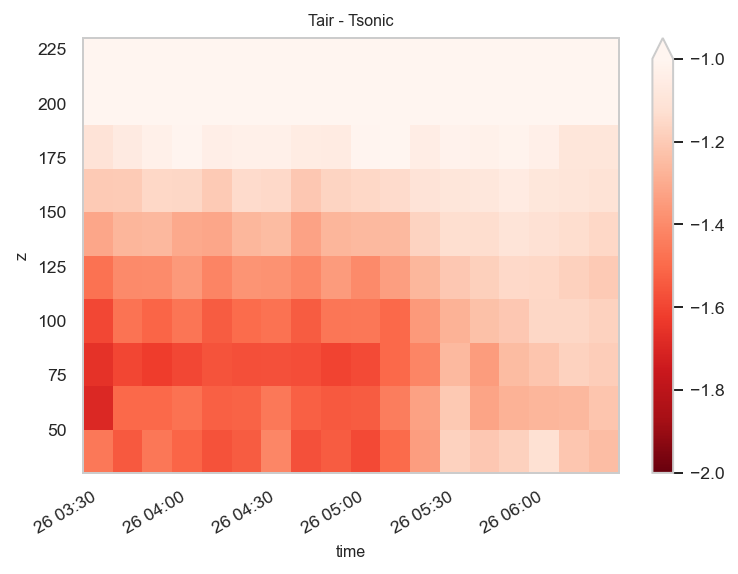

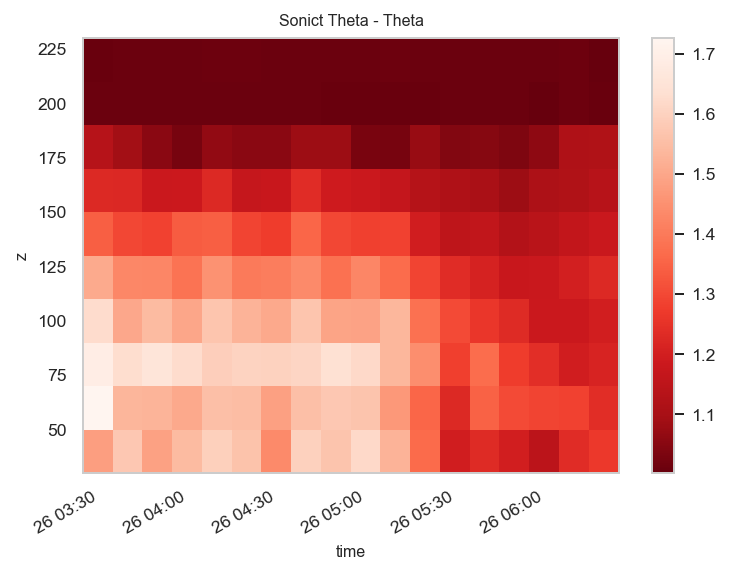

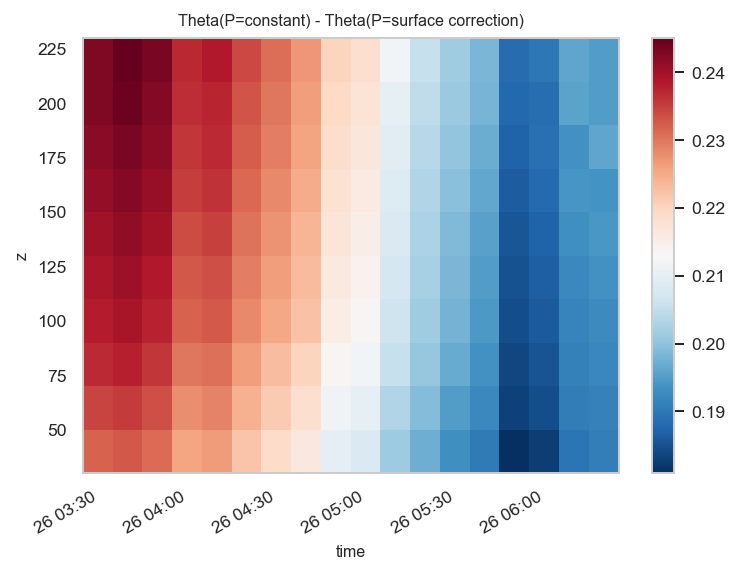

In [21]:
for ff, times in flight_times.items():
    # Just plot the 26th as it is the day of interest for the modeling study
    if '26' not in ff:
        continue
    
    t1 = pd.Timestamp(times[0])
    t2 = pd.Timestamp(times[-1])
    
    plt.figure()
    ds_plot = sodar.sel(time=slice(t1, t2)).sel(z=slice(None, 220))
    (ds_plot.temperature - 273.15 - ds_plot.sonic_temperature).T.plot(cmap='Reds_r', vmin=-2, vmax=-1)
    plt.gca().set_title('Tair - Tsonic')
    
    plt.figure()
    ds_plot = sodar.sel(time=slice(t1, t2)).sel(z=slice(None, 220))
    (ds_plot.sonic_theta - ds_plot.theta).T.plot(cmap='Reds_r')
    plt.gca().set_title('Sonict Theta - Theta')
    
    plt.figure()
    ds_plot = sodar.sel(time=slice(t1, t2)).sel(z=slice(None, 220))
    (ds_plot.theta - ds_plot.theta_tvary).T.plot(cmap='RdBu_r')
    plt.gca().set_title('Theta(P=constant) - Theta(P=surface correction)')

Variations within flights between the different pressure assumptions do not matter very much.

# Profile comparisons

## Convert non-sonic temperatures to sonic temperature in order to compare to the SODAR

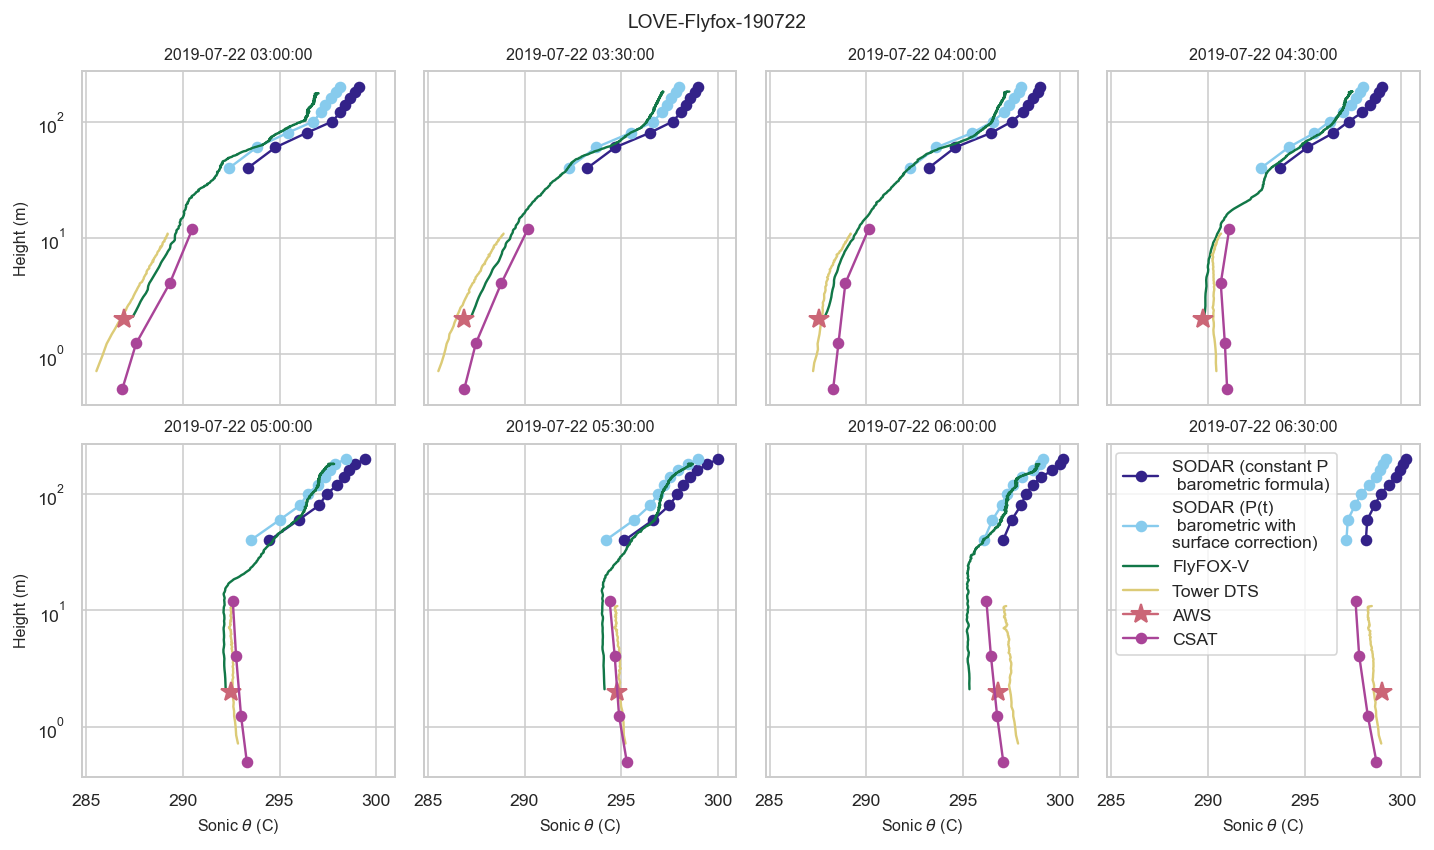

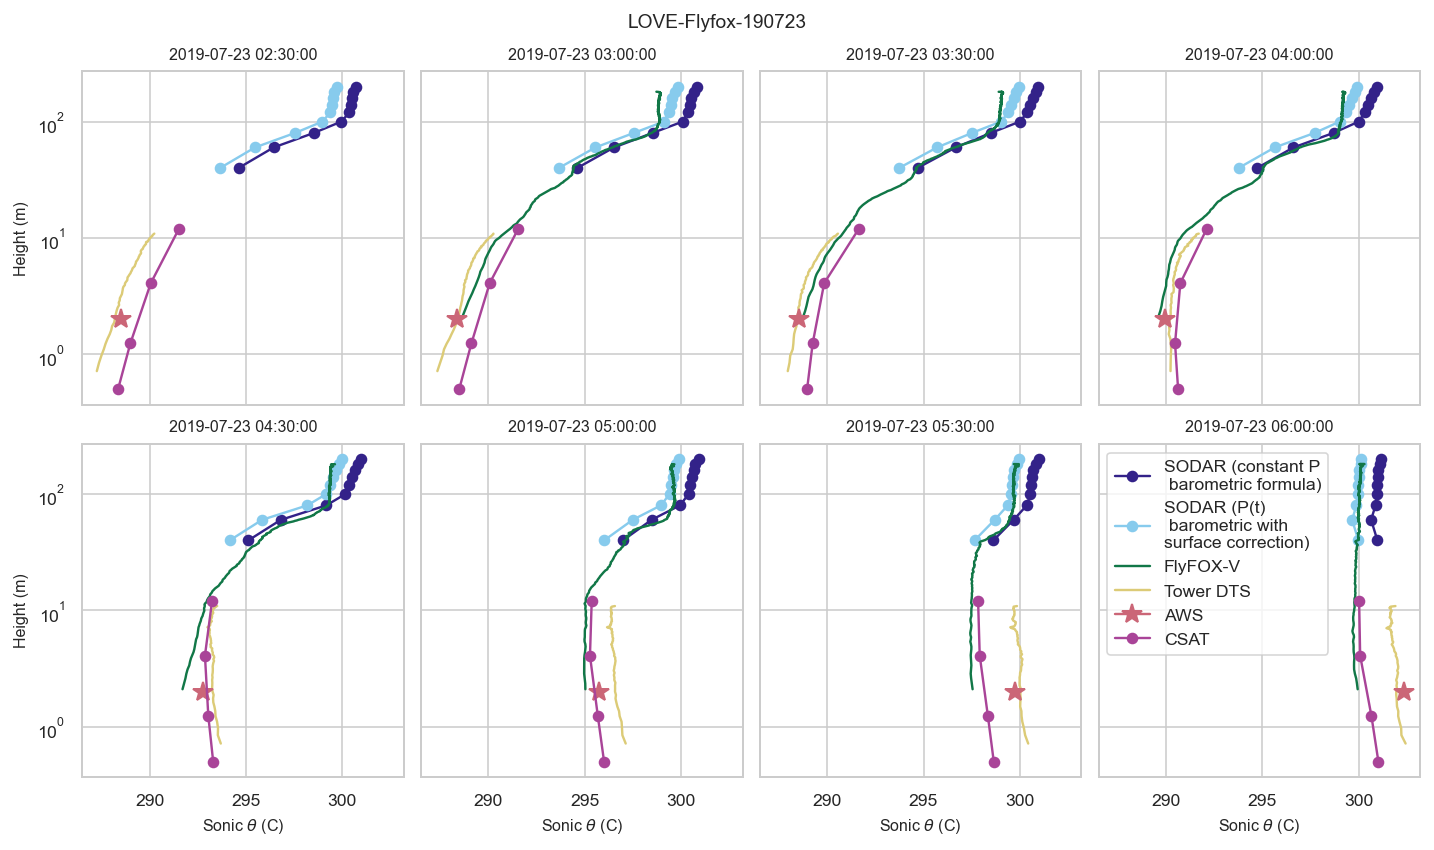

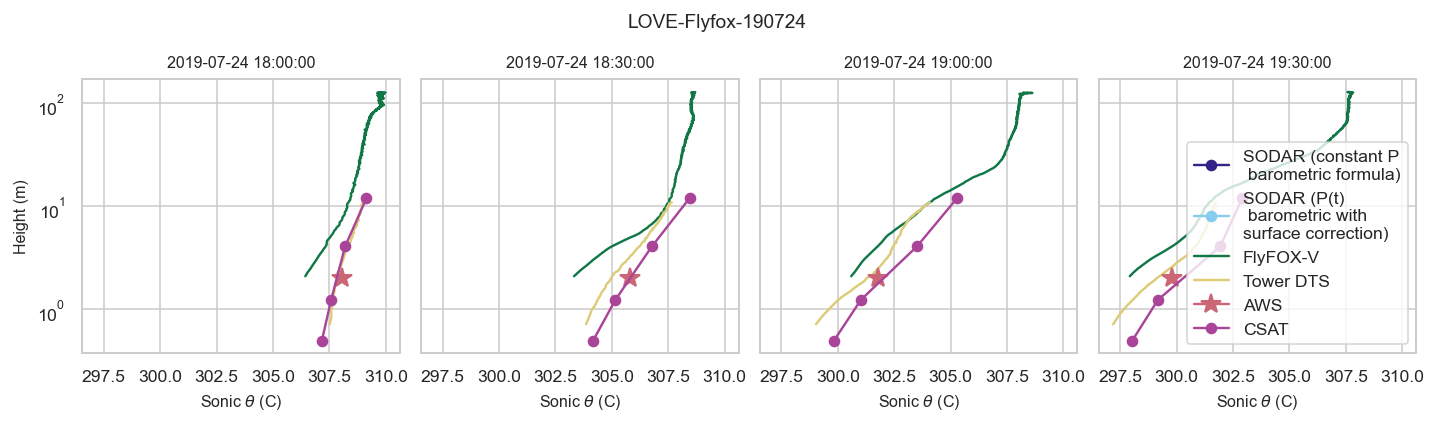

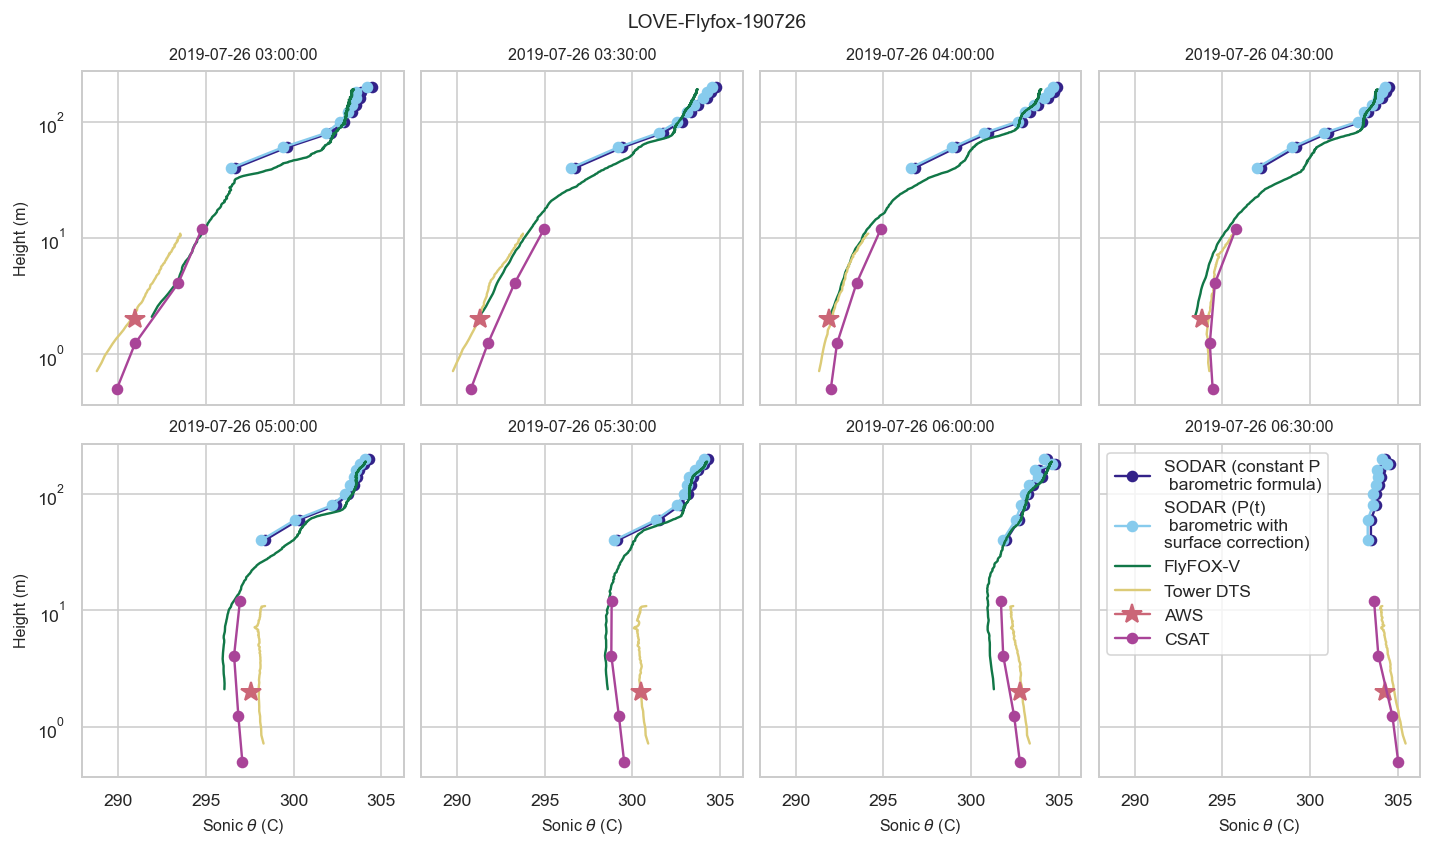

In [22]:
for ff in flight_times:
    if '18' in ff:
        continue
    t_list = pd.date_range(
        start=pd.Timestamp(flight_times[ff][0]).floor('30min'),
        end=pd.Timestamp(flight_times[ff][1]).ceil('30min'),
        freq='30min')

    if '24' not in ff:
        fig, axes = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(10, 6))
        n_iter = 8
    else:
        fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(10, 3))
        n_iter = 4
    axes = axes.flatten()

    for nt, t1 in enumerate(t_list[0:n_iter]):
        t2 = t1 + pd.Timedelta(minutes=30)
        tslice = slice(t1, t2)
        ax = axes[nt]
        
        # First, gather the necessary ancillary data for the calculation
        rh = aws['rel humidity 2m (HMP45)'].sel(time=tslice).mean(dim='time')
        T = aws['air temperature 2m (HMP45)'].sel(time=tslice).mean(dim='time')
        P = press_avg.sel(time=tslice).mean(dim='time') * 10
        # Saturation vapor pressure
        es = e_s_wmo(T)
        # Vapor pressure
        e = es * rh / 100
        # Specific humidity
        r_v = mixing_ratio(e, P)

        # SODAR quantities
        ds_plot = sodar.sel(time=tslice).mean(dim='time').sonic_theta + 273.15
        ds_plot = ds_plot.where(ds_plot.z < 220)
        ax.semilogy(ds_plot, ds_plot.z, marker='o', label='SODAR (constant P\n barometric formula)')
        
        ds_plot = sodar.sel(time=tslice).mean(dim='time').sonic_theta_tvary + 273.15
        ds_plot = ds_plot.where(ds_plot.z < 220)
        ax.semilogy(ds_plot, ds_plot.z, marker='o', label='SODAR (P(t)\n barometric with\nsurface correction)')

        # Convert all other quantities to virtual potential temperature
        ds_plot = flight_dict[ff].sel(time=tslice).mean(dim='time').theta_p_stnd
        ds_plot = ds_plot.where(ds_plot.z < 190)
        ds_plot = temp_sonic_conversion(ds_plot, flight_dict[ff].sel(time=tslice).mean(dim='time')['r_v_interp'])
        ax.semilogy(ds_plot, ds_plot.z, label='FlyFOX-V')

        ds_plot = tower.sel(time=tslice).mean(dim='time').theta + 273.15
        ds_plot = temp_sonic_conversion(ds_plot, r_v)
        ax.semilogy(ds_plot, tower.z, label='Tower DTS')

        ds_plot = aws_2m_theta.sel(time=tslice).mean(dim='time') + 273.15
        ds_plot = temp_sonic_conversion(ds_plot, r_v)
        ax.semilogy(ds_plot, 2, marker='*', markersize=10, label='AWS')
        
        ds_plot = sonic_1min_sub.theta.sel(time=tslice).mean(dim='time') + 273.15
        ds_plot = temp_sonic_conversion(ds_plot, r_v)
        ax.semilogy(ds_plot, sonic_1min_sub.z, marker='o', label='CSAT')

        if ax.is_first_col():
            ax.set_ylabel('Height (m)')
        if ax.is_last_row():
            ax.set_xlabel(r'Sonic $\theta$ (C)')
        ax.set_title(t1)

    fig.suptitle(ff)
    fig.tight_layout()
    axes[-1].legend()

## Use the SODAR temperatures to compare to other temperature observations

The above profiles should be nearly identical to the below profiles -- this is a sanity check.

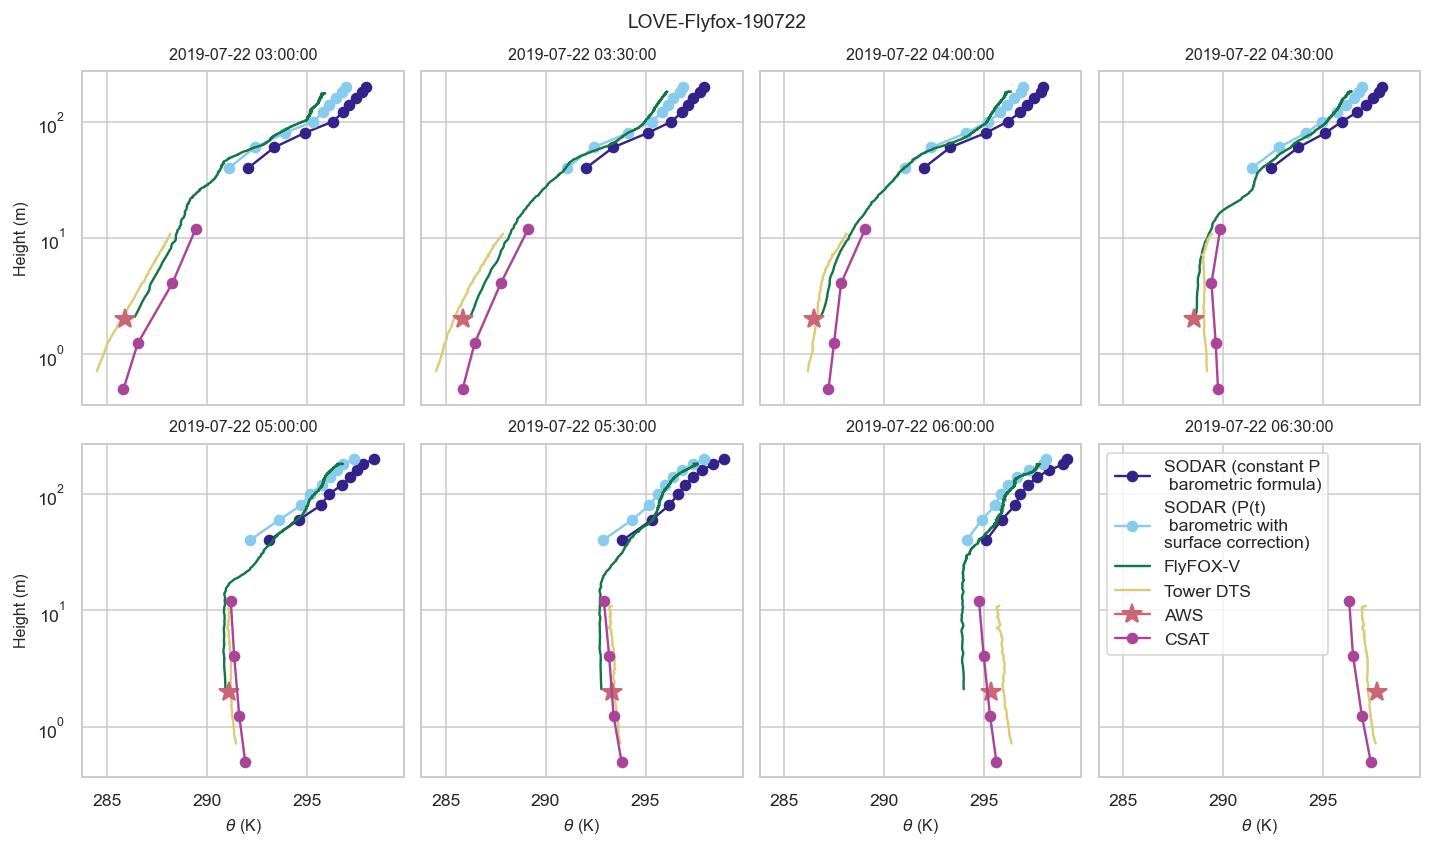

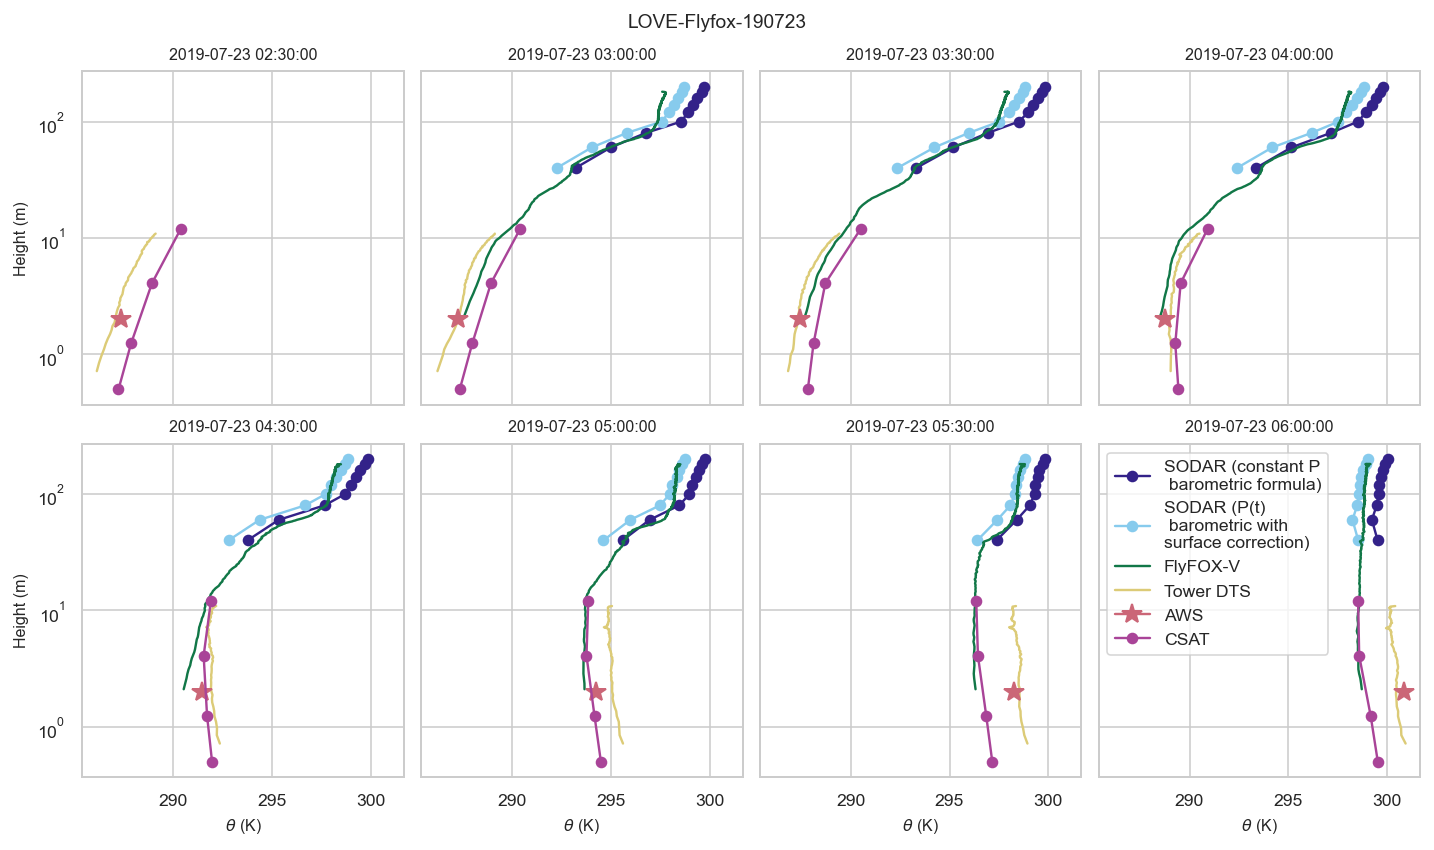

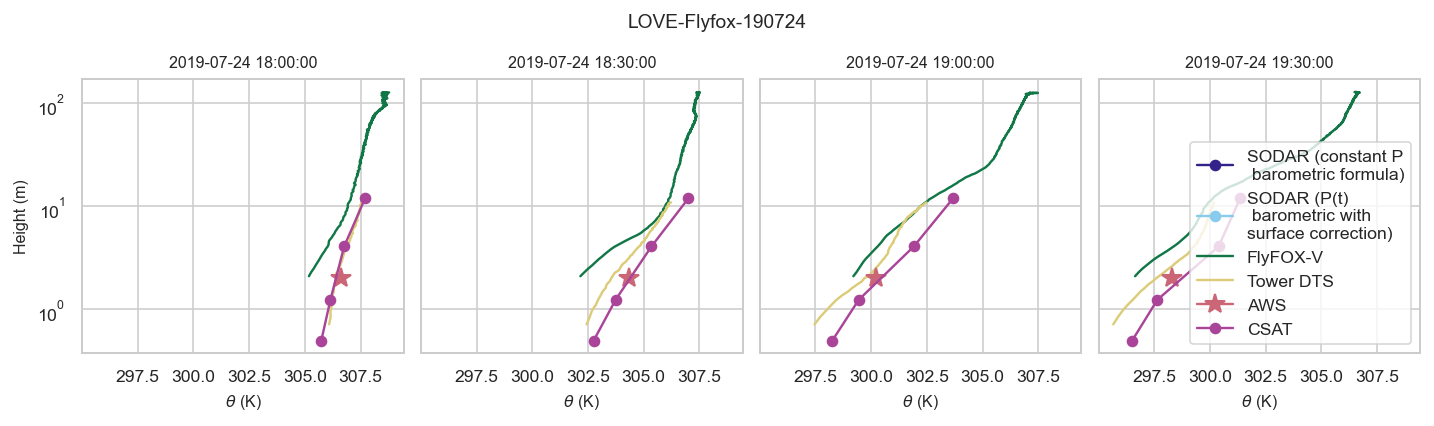

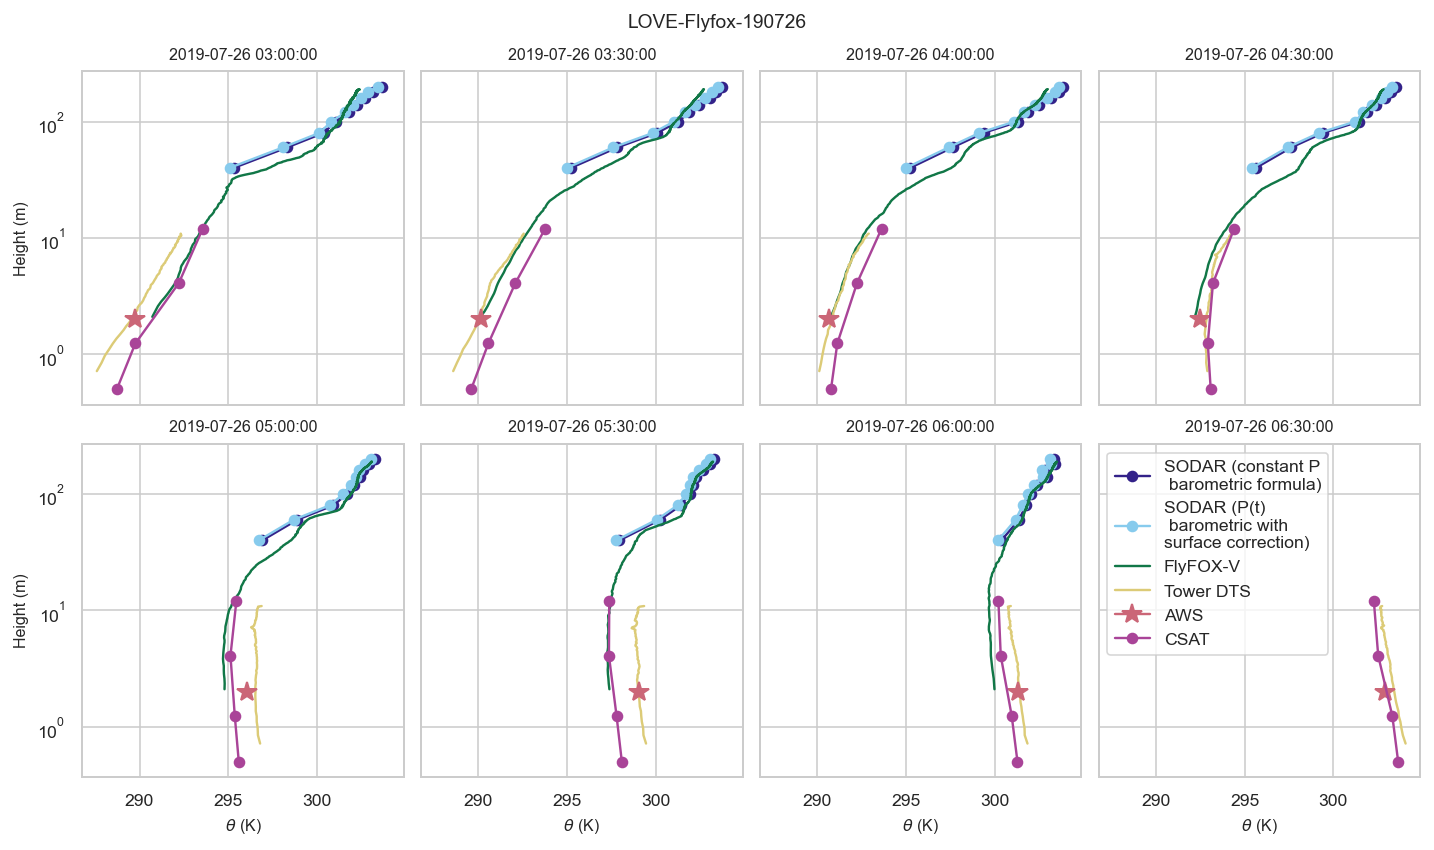

In [23]:
for ff in flight_times:
    if '18' in ff:
        continue
    t_list = pd.date_range(
        start=pd.Timestamp(flight_times[ff][0]).floor('30min'),
        end=pd.Timestamp(flight_times[ff][1]).ceil('30min'),
        freq='30min')

    if '24' not in ff:
        fig, axes = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(10, 6))
        n_iter = 8
    else:
        fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(10, 3))
        n_iter = 4
    axes = axes.flatten()

    for nt, t1 in enumerate(t_list[0:n_iter]):
        t2 = t1 + pd.Timedelta(minutes=30)
        tslice = slice(t1, t2)
        ax = axes[nt]

        # SODAR quantities
        ds_plot = sodar.sel(time=tslice).mean(dim='time').theta + 273.15
        ds_plot = ds_plot.where(ds_plot.z < 220)
        ax.semilogy(ds_plot, ds_plot.z, marker='o', label='SODAR (constant P\n barometric formula)')
        
        ds_plot = sodar.sel(time=tslice).mean(dim='time').theta_tvary + 273.15
        ds_plot = ds_plot.where(ds_plot.z < 220)
        ax.semilogy(ds_plot, ds_plot.z, marker='o', label='SODAR (P(t)\n barometric with\nsurface correction)')

        # Convert all other quantities to virtual potential temperature
        ds_plot = flight_dict[ff].sel(time=tslice).mean(dim='time').theta_p_stnd
        ds_plot = ds_plot.where(ds_plot.z < 190)
        ax.semilogy(ds_plot, ds_plot.z, label='FlyFOX-V')

        ds_plot = tower.sel(time=tslice).mean(dim='time').theta + 273.15
        ax.semilogy(ds_plot, tower.z, label='Tower DTS')

        ds_plot = aws_2m_theta.sel(time=tslice).mean(dim='time') + 273.15
        ax.semilogy(ds_plot, 2, marker='*', markersize=10, label='AWS')
        
        ds_plot = sonic_1min_sub.theta.sel(time=tslice).mean(dim='time') + 273.15
        ax.semilogy(ds_plot, sonic_1min_sub.z, marker='o', label='CSAT')

        if ax.is_first_col():
            ax.set_ylabel('Height (m)')
        if ax.is_last_row():
            ax.set_xlabel(r'$\theta$ (K)')
        ax.set_title(t1)

    fig.suptitle(ff)
    fig.tight_layout()
    axes[-1].legend()

Generally, I think that it makes more sense to correct the SODAR's sonic temperature to air temperature when possible than to convert other quantities to sonic temperature. We don't have enough information regarding the humidity to make it a really good fix.

## Example of correcting for local topography

The addition to z for the FlyFOX launch site comes from the theodolit data, which allows me to correct for absolute height, not just height above the local surface. The site is on a slight slope with the tower being about -1.5m and FlyFOX being +1.5m relative to the theodolit reference height. Since everything by the tower has height relative to the surface, I just account for the height difference between the FlyFOX winch and the surface by the tower.

The tower base is -1.5m relative to the theodolit. The FlyFOX winch is +1.5m relative to the theodolit. I estimate that the winch is ~0.5m tall, so the actual height above the surface is maybe something like 2.5m.

*Important note*: FlyFOX is the least accurate nearest the surface. The height just above the surface was estimate, the fiber bends significantly near the surface. This is the height we should believe the least.

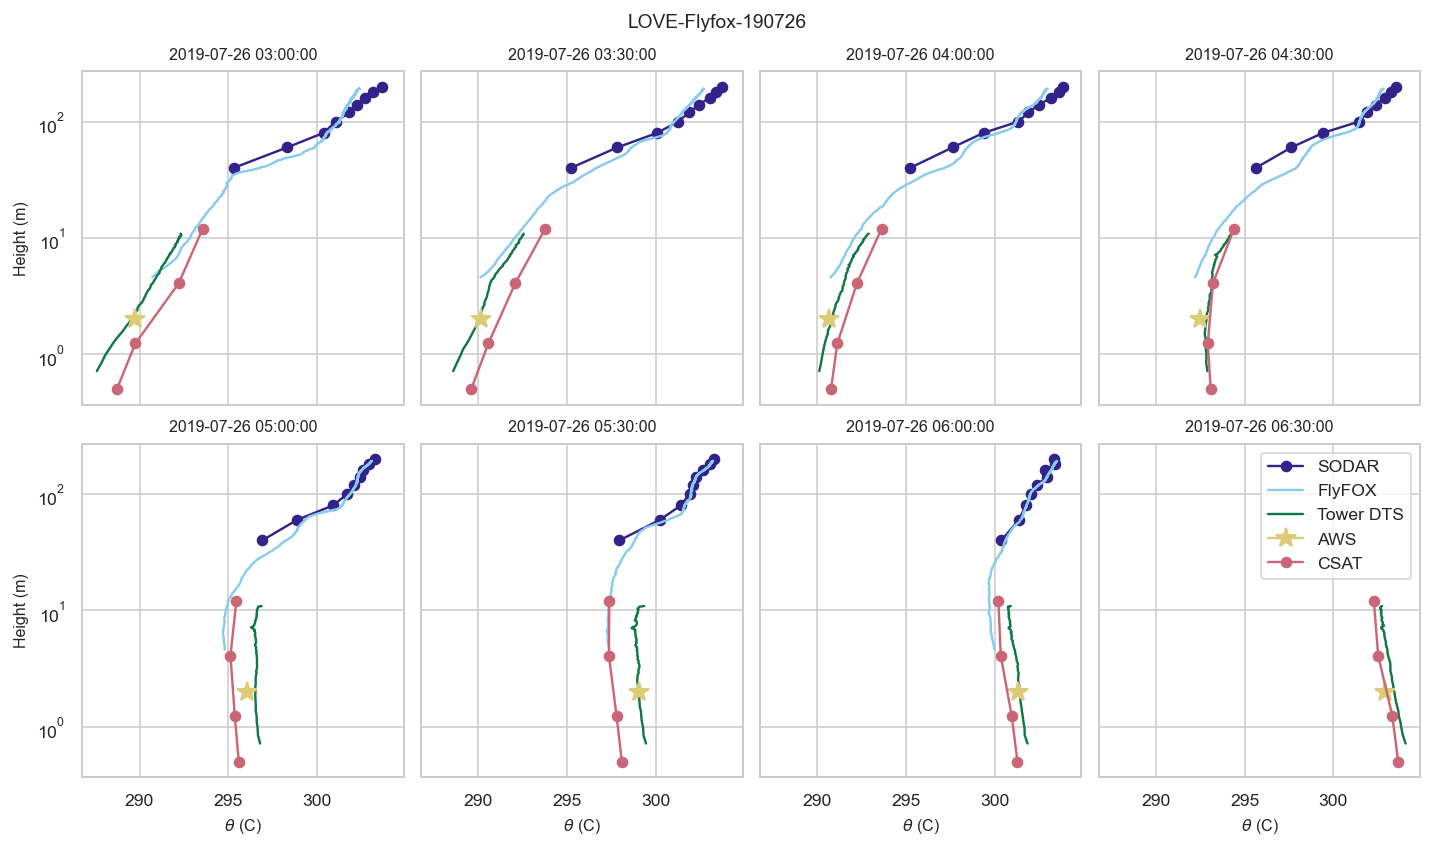

In [24]:
t_list = pd.date_range(start='2019-07-26 03:00', end='2019-07-26 06:30', freq='30min')
fig, axes = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(10, 6))
axes = axes.flatten()

for nt, t1 in enumerate(t_list):
    t2 = t1 + pd.Timedelta(minutes=30)
    tslice = slice(t1, t2)

    ax = axes[nt]
    ds_plot = sodar.sel(time=tslice).mean(dim='time').theta + 273.15
    ds_plot = ds_plot.where(ds_plot.z < 220)
    ax.semilogy(ds_plot, ds_plot.z, marker='o', label='SODAR')
    
    ds_plot = ff_26.sel(time=tslice).mean(dim='time').theta_p_stnd
    ds_plot = ds_plot.where(ds_plot.z < 190)
    ax.semilogy(ds_plot, ds_plot.z + 2.5, label='FlyFOX')

    ds_plot = tower.sel(time=tslice).mean(dim='time').theta + 273.15
    ax.semilogy(ds_plot, tower.z, label='Tower DTS')

    ds_plot = aws_2m_theta.sel(time=tslice).mean(dim='time') + 273.15
    ax.semilogy(ds_plot, 2, marker='*', markersize=10, label='AWS')

    ds_plot = sonic_1min_sub.theta.sel(time=tslice).mean(dim='time') + 273.15
    ax.semilogy(ds_plot, sonic_1min_sub.z, marker='o', label='CSAT')
        
    if ax.is_first_col():
        ax.set_ylabel('Height (m)')
    if ax.is_last_row():
        ax.set_xlabel(r'$\theta$ (C)')
    ax.set_title(t1)
    
fig.suptitle(ff)
fig.tight_layout()
axes[-1].legend()

No real conclusion can be drawn from the profiles alone since we have demonstrated there is substantial heterogeneity in the near surface temperatures between FlyFOX and the tower in Fritz et al., 2021.

# FlyFOX-SODAR comparison

Here I aggregate the FlyFOX to the SODAR's resolution in order to visualize the difference between these data. The above profiles already suggest we should see them agree within the SBL and disagree within the residual layer.

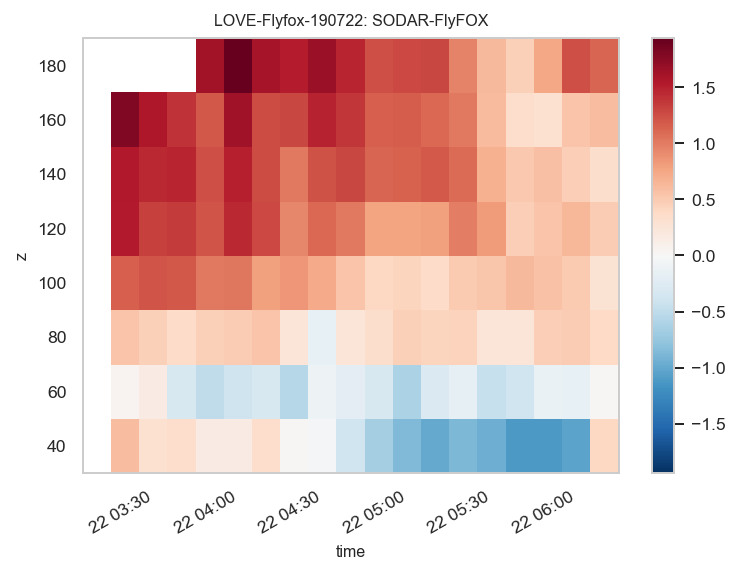

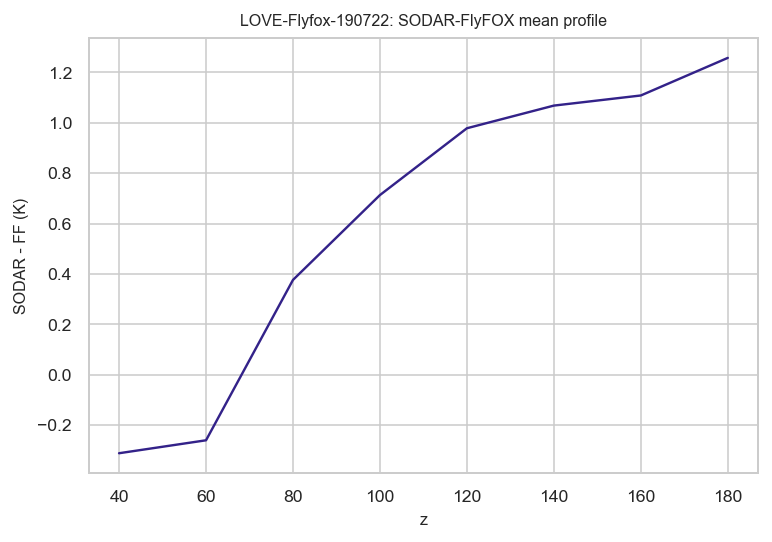

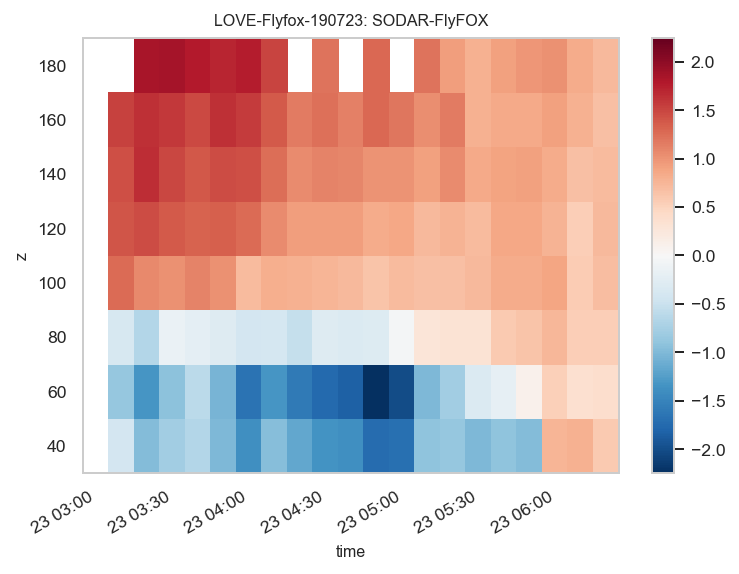

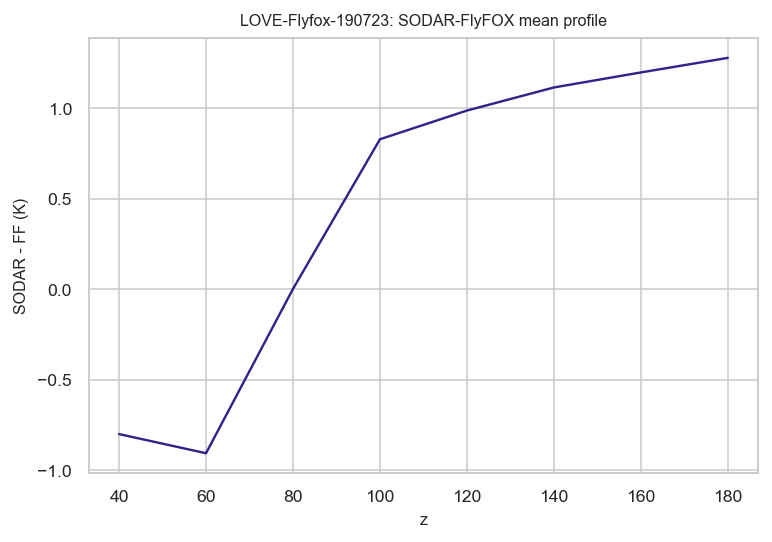

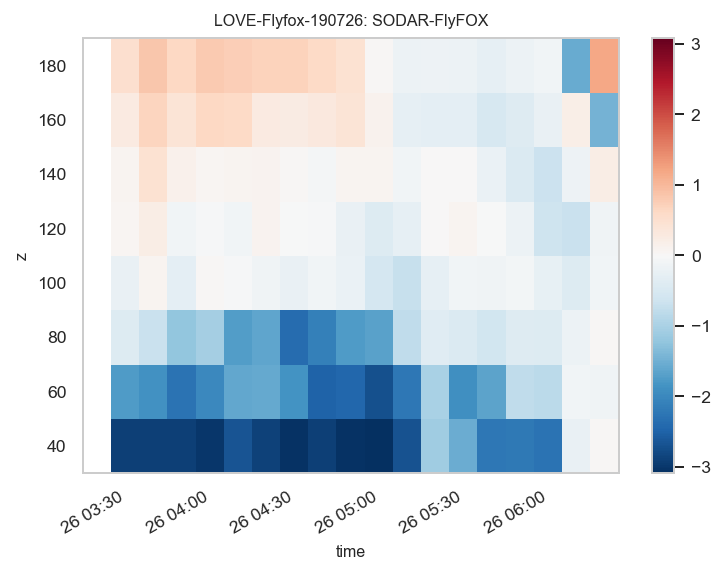

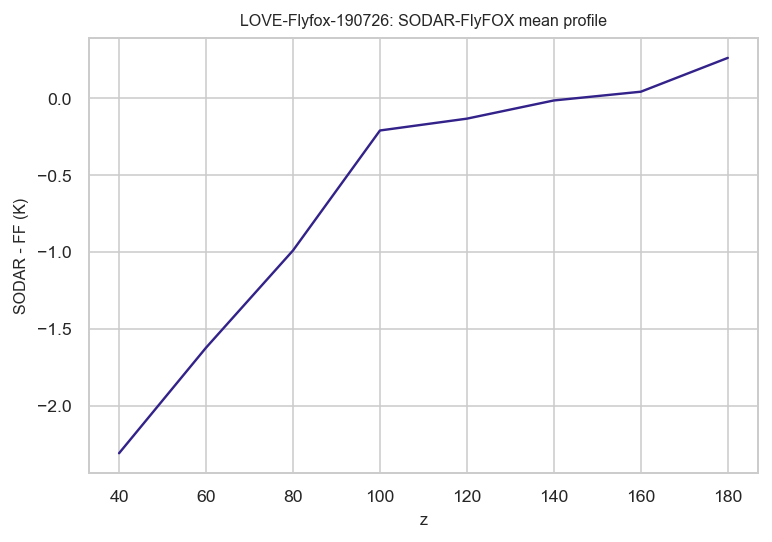

In [25]:
for ff in flight_dict:
    if '18' in ff or '24' in ff:
        continue
    # Aggreate the FlyFOX data to the SODAR resolution
    z_bins = np.arange(0, 220, 20)
    z_bin_labels = np.arange(0, 200, 20)
    ds_comp_ff = flight_dict[ff].theta_p_stnd.groupby_bins('z', z_bins, labels=z_bin_labels, ).mean() - 273.15
    ds_comp_ff = ds_comp_ff.resample(time='10min').mean()

    ds_comp_sodar = sodar.sel(time=slice(ds_comp_ff.time[0], ds_comp_ff.time[-1]))
    ds_comp_sodar = ds_comp_sodar.sel(z=slice(None, 200))

    plt.figure()
    (ds_comp_sodar.theta - ds_comp_ff.rename({'z_bins': 'z'})).T.plot()
    plt.gca().set_title(ff + ': SODAR-FlyFOX')

    plt.figure()
    (ds_comp_sodar.theta - ds_comp_ff.rename({'z_bins': 'z'})).mean(dim='time').plot()
    plt.gca().set_ylabel('SODAR - FF (K)')
    plt.gca().set_title(ff + ': SODAR-FlyFOX mean profile')


Generally, a cold bias in the SBL and a warm bias above it. Biases like this could not be explained by errors in the FlyFOX thermodynamic quantities since:
- FlyFox agrees well enough with the surface observations
- SODAR and FlyFOX thermodynamic quantities were derived using similar assumptions

Other errors like height of FlyFOX could not explain this error shape since the residual layer has such a small temperature gradient. A height error would instead come off as an error around the SBL top, at the strongest temperature gradients.

Instead, it seems to be related to stability. Stable conditions = cold biases. Neutral stability = warm biases. We can see this on the 23rd when we resolve the entire morning transition. 

# Finally, output the new version of the sodar data

I feel justified using the thermodynamic quantities derived using the pressure corrected to the surface pressure.

In [27]:
# Drop the quantities derived using the barometric pressure without surface adjustments
sodar = sodar.drop(['sonic_theta', 'press_baro', 'theta'])
# and rename the quantities derived using the barometric pressure with the
# surface adjustments.
sodar = sodar.rename({
    'theta_tvary': 'theta',
    'press_baro_tvary': 'press_baro',
    'sonic_theta_tvary': 'sonic_theta',
})

# Add missing attributes
sodar['theta'] = sodar['theta'] + 273.15
sodar.theta.attrs['description'] = 'Potential temperature, only available during FlyFOX-V when RH profiles could be estimated'
sodar.theta.attrs['units'] = 'K'
sodar.theta.attrs['processing'] = (
    'Sonic temperature converted to temperature. Potential temperature estimated using '
    'barometric formula and adjusted according to surface pressure perturbations')

sodar.temperature.attrs['description'] = 'Temperature, only available during FlyFOX-V when RH profiles could be estimated'
sodar.temperature.attrs['processing'] = 'Sonic temperature converted to temperature during FlyFOX-V when RH profiles could be estimated.'
sodar.temperature.attrs['units'] = 'K'

sodar.sonic_temperature.attrs['description'] = 'Sonic temperature, original instrument output'
sodar.sonic_temperature.attrs['units'] = 'K'
sodar['sonic_temperature'] = sodar['sonic_temperature'] + 273.15

sodar.sonic_theta.attrs['description'] = 'Sonic potential temperature'
sodar.sonic_theta.attrs['units'] = 'K'
sodar['sonic_temperature'] = sodar['sonic_temperature'] + 273.15
sodar.sonic_theta.attrs['processing'] = (
    'Potential temperature estimated using '
    'barometric formula and adjusted according to surface pressure perturbations')

sodar.r_v_interp.attrs['description'] = 'Specific humidity of water vapor. Only available during FlyFOX-V.'
sodar.r_v_interp.attrs['units'] = 'kg/kg'
sodar.r_v_interp.attrs['processing'] = 'Estimated using press_baro and a linear interpolation between surface and tethersonde RH.'

sodar.press_baro.attrs['description'] = 'Barometric formula estimated pressure'
sodar.press_baro.attrs['units'] = 'kPa'
sodar.press_baro.attrs['processing'] = 'Barometric formula with adjustments according to surface pressure perturbations'

sodar

<xarray.Dataset>
Dimensions:            (time: 8784, z: 19)
Coordinates:
  * time               (time) datetime64[ns] 2019-05-31T23:00:00 ... 2019-07-...
  * z                  (z) int64 40 60 80 100 120 140 ... 320 340 360 380 400
Data variables:
    sonic_temperature  (time, z) float64 560.3 561.2 562.3 ... 563.5 565.6 565.2
    wind_speed         (time, z) float64 ...
    wind_direction     (time, z) float64 ...
    r_v_interp         (time, z) float64 nan nan nan nan nan ... nan nan nan nan
    temperature        (time, z) float64 nan nan nan nan nan ... nan nan nan nan
    press_baro         (z, time) float64 nan nan nan nan ... 90.19 90.19 90.2
    sonic_theta        (time, z) float64 nan nan nan nan ... 25.44 27.87 27.65
    theta              (time, z) float64 nan nan nan nan nan ... nan nan nan nan

In [28]:
os.chdir(dir_sodar)
sodar.to_netcdf('LOVE_SODAR_JuneJuly.v2-2021-06-02.nc')